# Resonances classification via MLP and CNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

# Train and validation data preparation


In [2]:
! git clone https://github.com/Marcello-Bacchi/ML_exam_unipv.git
! curl https://github.com/Marcello-Bacchi/ML_exam_unipv.git

Cloning into 'ML_exam_unipv'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 101 (delta 5), reused 7 (delta 2), pack-reused 87
Receiving objects: 100% (101/101), 115.40 MiB | 11.64 MiB/s, done.
Resolving deltas: 100% (83/83), done.
Updating files: 100% (85/85), done.
<html>
<head><title>301 Moved Permanently</title></head>
<body>
<center><h1>301 Moved Permanently</h1></center>
<hr><center>nginx</center>
</body>
</html>


In [3]:
datafile = '/content/ML_exam_unipv/resonances_dataset.h5'

f = h5py.File(datafile)
print(f.keys())

<KeysViewHDF5 ['resonances']>


In [4]:
##### Define vectors for MLP model ######

features_MLP = np.array(f.get('resonances')[:,0:2000])
target_MLP = np.array(f.get('resonances')[:,-1])

print(target_MLP.shape, features_MLP.shape)


##### Define vectors for CNN model ######

features_CNN = np.reshape(features_MLP,(-1,2000,1))
target_CNN = np.reshape(target_MLP,(-1,1,1))

print(target_CNN.shape, features_CNN.shape)

(3000,) (3000, 2000)
(3000, 1, 1) (3000, 2000, 1)


In [5]:
######### Data shuffle with 2:1 splitting ratio MLP ##########

from sklearn.model_selection import train_test_split
X_train_MLP, X_val_MLP, y_train_MLP, y_val_MLP = train_test_split(features_MLP, target_MLP, test_size=0.33)
print(X_train_MLP.shape, X_val_MLP.shape, y_train_MLP.shape, y_val_MLP.shape)
del features_MLP, target_MLP

(2010, 2000) (990, 2000) (2010,) (990,)


In [6]:
######### Data shuffle with 2:1 splitting ratio CNN ##########

from sklearn.model_selection import train_test_split
X_train_CNN, X_val_CNN, y_train_CNN, y_val_CNN = train_test_split(features_CNN, target_CNN, test_size=0.33)
print(X_train_CNN.shape, X_val_CNN.shape, y_train_CNN.shape, y_val_CNN.shape)
del features_CNN, target_CNN

(2010, 2000, 1) (990, 2000, 1) (2010, 1, 1) (990, 1, 1)


In [7]:
######## Keras imports for MLP and CNN #########

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Activation, Conv1D, AveragePooling1D
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

# MLP model

In [23]:
input_shape = X_train_MLP.shape[1]
dropoutRate = 0.25

inputArray = Input(shape=(input_shape))

######### FIRST LAYER ##########
x = Dense(30, activation='relu')(inputArray)
x = Dropout(dropoutRate)(x)

######### SECOND LAYER ##########
x = Dense(30)(x)
x = Activation('relu')(x)
x = Dropout(dropoutRate)(x)

######### THIRD LAYER ##########
x = Dense(20)(x)
x = Activation('relu')(x)
x = Dropout(dropoutRate)(x)

output_MLP = Dense(1, activation='sigmoid')(x)

model_MLP = Model(inputs=inputArray, outputs=output_MLP)


model_MLP.compile(loss='binary_crossentropy', optimizer='adam')
model_MLP.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense_15 (Dense)            (None, 30)                60030     
                                                                 
 dropout_10 (Dropout)        (None, 30)                0         
                                                                 
 dense_16 (Dense)            (None, 30)                930       
                                                                 
 activation_6 (Activation)   (None, 30)                0         
                                                                 
 dropout_11 (Dropout)        (None, 30)                0         
                                                                 
 dense_17 (Dense)            (None, 20)                620 

In [24]:
batch_size = 128
n_epochs = 50

# train
history = model_MLP.fit(X_train_MLP, y_train_MLP, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val_MLP, y_val_MLP),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Epoch 1/50
16/16 - 2s - loss: 0.6991 - val_loss: 0.6843 - lr: 0.0010 - 2s/epoch - 118ms/step
Epoch 2/50
16/16 - 0s - loss: 0.6760 - val_loss: 0.6741 - lr: 0.0010 - 99ms/epoch - 6ms/step
Epoch 3/50
16/16 - 0s - loss: 0.6628 - val_loss: 0.6655 - lr: 0.0010 - 99ms/epoch - 6ms/step
Epoch 4/50
16/16 - 0s - loss: 0.6505 - val_loss: 0.6586 - lr: 0.0010 - 103ms/epoch - 6ms/step
Epoch 5/50
16/16 - 0s - loss: 0.6402 - val_loss: 0.6546 - lr: 0.0010 - 107ms/epoch - 7ms/step
Epoch 6/50
16/16 - 0s - loss: 0.6367 - val_loss: 0.6532 - lr: 0.0010 - 103ms/epoch - 6ms/step
Epoch 7/50
16/16 - 0s - loss: 0.6322 - val_loss: 0.6535 - lr: 0.0010 - 101ms/epoch - 6ms/step
Epoch 8/50

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
16/16 - 0s - loss: 0.6263 - val_loss: 0.6546 - lr: 0.0010 - 105ms/epoch - 7ms/step
Epoch 9/50
16/16 - 0s - loss: 0.6311 - val_loss: 0.6547 - lr: 1.0000e-04 - 111ms/epoch - 7ms/step
Epoch 10/50

Epoch 10: ReduceLROnPlateau reducing learning rate to 1.000000

# Results MLP

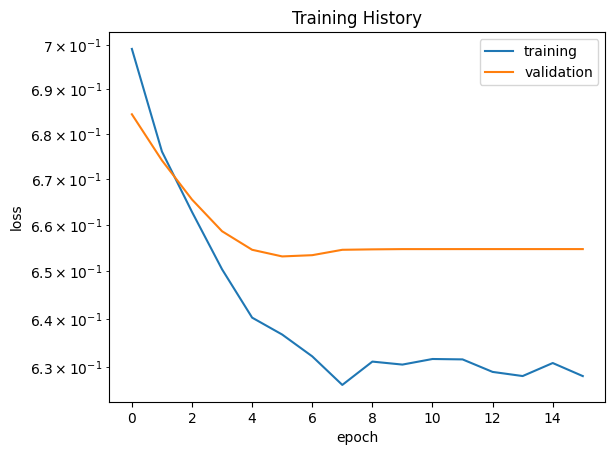

In [25]:
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

31/31 [==============================] - 0s 2ms/step


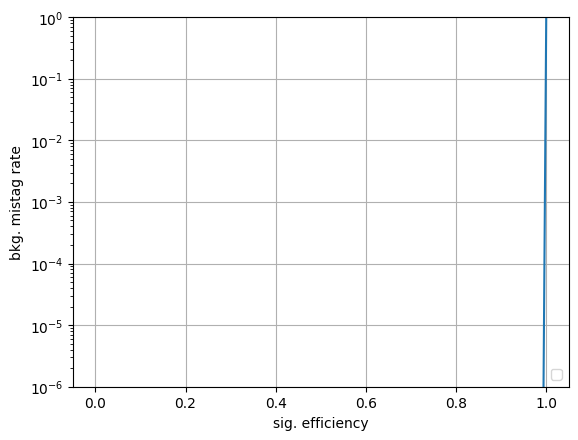

0.5


In [11]:
from sklearn.metrics import roc_curve, auc

predict_val_MLP = model_MLP.predict(X_val_MLP)

fpr_MLP = {}
tpr_MLP = {}
auc_MLP = {}
#label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.)
#plt.figure()
fpr_MLP, tpr_MLP, threshold = roc_curve(y_val_MLP, predict_val_MLP)
auc_MLP = auc(fpr_MLP, tpr_MLP)

plt.plot(tpr_MLP, fpr_MLP)
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()

print(auc_MLP)

# CNN model

In [12]:
featureArrayLength = (X_train_CNN.shape[1],X_train_CNN.shape[2])
dropoutRate = 0.25

####
inputList = Input(shape=(featureArrayLength))
x = Conv1D(5, kernel_size=3, data_format="channels_last", strides=1, padding="valid", activation='relu')(inputList)
x = AveragePooling1D(pool_size=3)(x)
#
x = Conv1D(10, kernel_size=3, data_format="channels_last", strides=1, padding="valid", activation='relu')(x)
x = AveragePooling1D(pool_size=3)(x)
"""#
x = Conv1D(60, kernel_size=2, data_format="channels_last", strides=1, padding="valid", activation='relu')(x)
x = AveragePooling1D(pool_size=9)(x)
#"""
x = Flatten()(x)
#x = Dense(20, activation='relu')(x)
#x = Dropout(dropoutRate)(x)
#x = Dense(10, activation='relu')(x)
#x = Dropout(dropoutRate)(x)
output_CNN = Dense(1, activation='sigmoid')(x)
####
model_CNN = Model(inputs=inputList, outputs=output_CNN)

model_CNN.compile(loss='binary_crossentropy', optimizer='adam')
model_CNN.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 1998, 5)           20        
                                                                 
 average_pooling1d (AverageP  (None, 666, 5)           0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 664, 10)           160       
                                                                 
 average_pooling1d_1 (Averag  (None, 221, 10)          0         
 ePooling1D)                                                     
                                                                 
 flatten (Flatten)           (None, 2210)              0   

In [13]:
batch_size = 128
n_epochs = 100

# train
history = model_CNN.fit(X_train_CNN, y_train_CNN, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val_CNN, y_val_CNN),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Epoch 1/100
16/16 - 6s - loss: 0.6898 - val_loss: 0.6779 - lr: 0.0010 - 6s/epoch - 392ms/step
Epoch 2/100
16/16 - 0s - loss: 0.6668 - val_loss: 0.6436 - lr: 0.0010 - 163ms/epoch - 10ms/step
Epoch 3/100
16/16 - 0s - loss: 0.6045 - val_loss: 0.5523 - lr: 0.0010 - 122ms/epoch - 8ms/step
Epoch 4/100
16/16 - 0s - loss: 0.4877 - val_loss: 0.4188 - lr: 0.0010 - 127ms/epoch - 8ms/step
Epoch 5/100
16/16 - 0s - loss: 0.3613 - val_loss: 0.3157 - lr: 0.0010 - 120ms/epoch - 8ms/step
Epoch 6/100
16/16 - 0s - loss: 0.2833 - val_loss: 0.2586 - lr: 0.0010 - 122ms/epoch - 8ms/step
Epoch 7/100
16/16 - 0s - loss: 0.2257 - val_loss: 0.2236 - lr: 0.0010 - 132ms/epoch - 8ms/step
Epoch 8/100
16/16 - 0s - loss: 0.1948 - val_loss: 0.2043 - lr: 0.0010 - 116ms/epoch - 7ms/step
Epoch 9/100
16/16 - 0s - loss: 0.1810 - val_loss: 0.1935 - lr: 0.0010 - 122ms/epoch - 8ms/step
Epoch 10/100
16/16 - 0s - loss: 0.1650 - val_loss: 0.1804 - lr: 0.0010 - 124ms/epoch - 8ms/step
Epoch 11/100
16/16 - 0s - loss: 0.1491 - val_loss

# CNN results

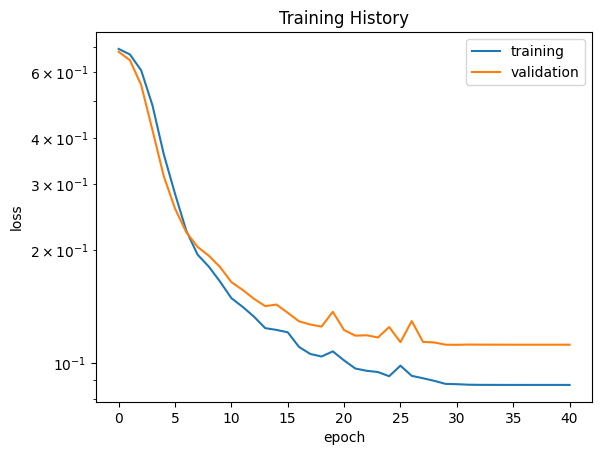

In [14]:
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

31/31 [==============================] - 0s 3ms/step


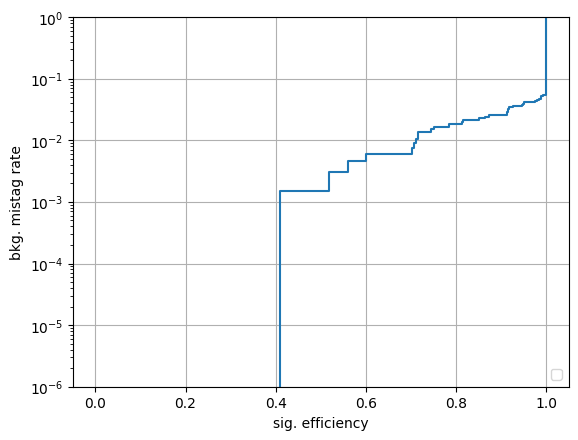

0.991267217630854


In [15]:
from sklearn.metrics import roc_curve, auc

predict_val_CNN = model_CNN.predict(X_val_CNN)
y_val_CNN = np.reshape(y_val_CNN,(990,1))
fpr_CNN = {}
tpr_CNN = {}
auc_CNN = {}
#label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.)
#plt.figure()
fpr_CNN, tpr_CNN, threshold = roc_curve(y_val_CNN, predict_val_CNN)
auc_CNN = auc(fpr_CNN, tpr_CNN)

plt.plot(tpr_CNN, fpr_CNN)
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()

print(auc_CNN)